# Dependencies

In [1]:
!git clone https://github.com/voxelmorph/voxelmorph.git # getting vxm from git to use scripts
!pip install neurite

Cloning into 'voxelmorph'...
remote: Enumerating objects: 3240, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 3240 (delta 14), reused 30 (delta 11), pack-reused 3202
Receiving objects: 100% (3240/3240), 129.20 MiB | 33.12 MiB/s, done.
Resolving deltas: 100% (2078/2078), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.3-py3-none-any.whl size=19530 sha256=ba92f63a02af5072aff40a9c6cdb66446ec24e56882e31ad97b18db94ecdf6eb
  Stored in directory: /root/.cache/pip/wheels/33/42/e2/6312e2cd3efadacc2714759efc7c7dc1513db7853e8bd508f6
Successfully built pystrum


In [2]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import sys 
sys.path.append('voxelmorph')
import voxelmorph as vxm
import time

import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

np.random.seed(777)
tf.random.set_seed(777)

# disable eager execution
# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.experimental.output_all_intermediates(True) # https://github.com/tensorflow/tensorflow/issues/54458

# Connect to driver

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Download dataset OASIS

In [5]:
# get neurite-OASIS data
!wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
!mkdir OASIS
!tar xf neurite-oasis.2d.v1.0.tar --directory 'OASIS'

--2023-06-03 19:00:41--  https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24903680 (24M) [application/x-tar]
Saving to: ‘neurite-oasis.2d.v1.0.tar’

neurite-oasis.2d.v1 100%[===================>]  23.75M  32.3MB/s    in 0.7s    

2023-06-03 19:00:42 (32.3 MB/s) - ‘neurite-oasis.2d.v1.0.tar’ saved [24903680/24903680]



# Download train and validation list

In [6]:
!cp "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Utils/processing-oasis-2d-results/train.txt" "/content/"

In [7]:
!cp "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Utils/processing-oasis-2d-results/validate.txt" "/content/"

# Load validate dataset

In [4]:
validate = []
with open("validate.txt", "r") as tfile:
    validate = [line.strip() for line in tfile.readlines()]

# Registrations

## Registration #1

### Brains

In [8]:
validate[0]

'/content/OASIS/OASIS_OAS1_0006_MR1/slice_norm.nii.gz'

In [9]:
validate[1]

'/content/OASIS/OASIS_OAS1_0010_MR1/slice_norm.nii.gz'

In [10]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[0]
registration_args.moving = validate[1]
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(
    registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warp = vxm.networks.VxmDense.load(registration_args.model, **config).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 211ms/step


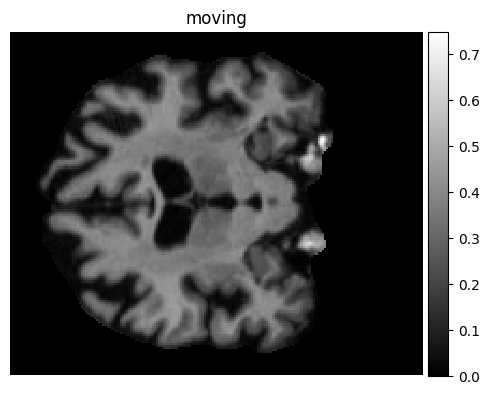

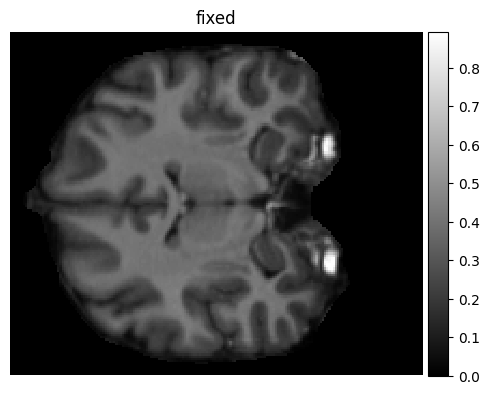

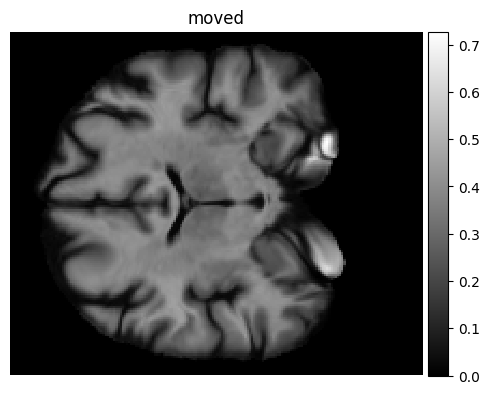

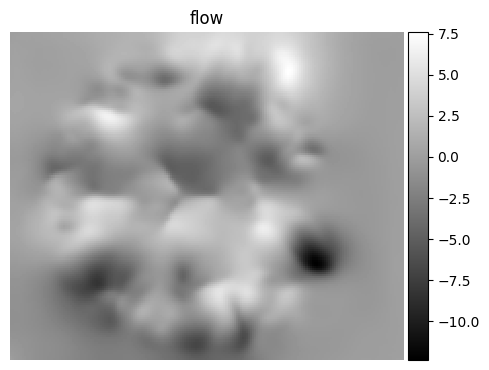

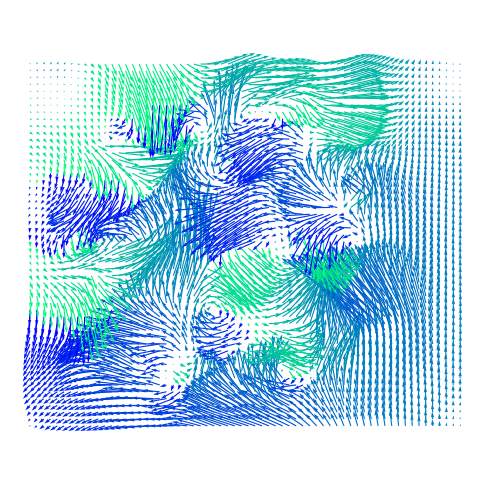

In [11]:
titles = ['moving', 'fixed', 'moved', 'flow']
for index, image in enumerate([moving, fixed, moved, warp]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

# visualize flow
flow = warp.squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

print()
print()

### Slice seg24

In [12]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[0].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moving = validate[1].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 224ms/step


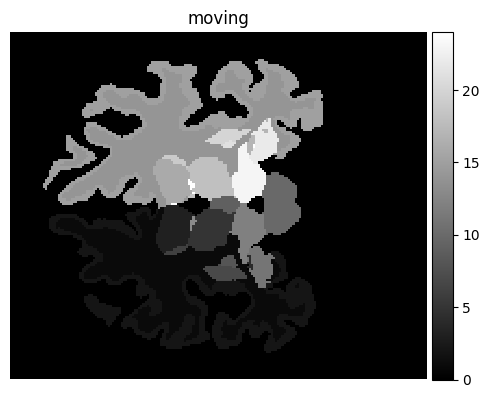

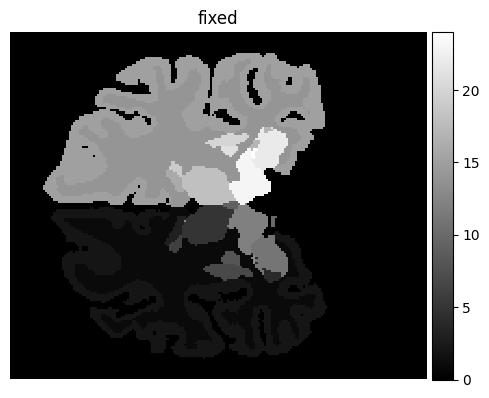

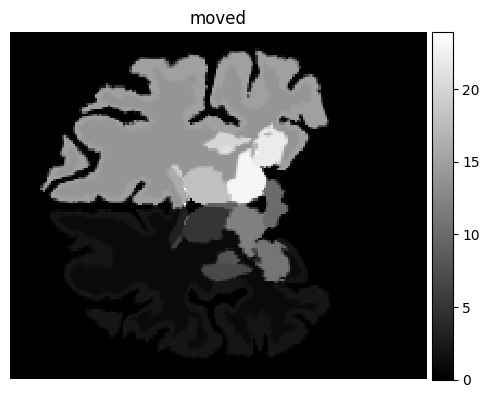

In [13]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

### Slice seg4

In [14]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[0].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moving = validate[1].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 225ms/step


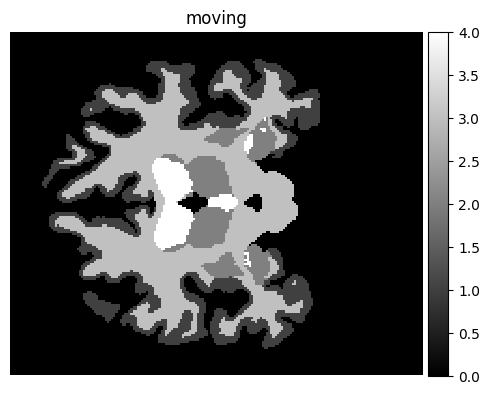

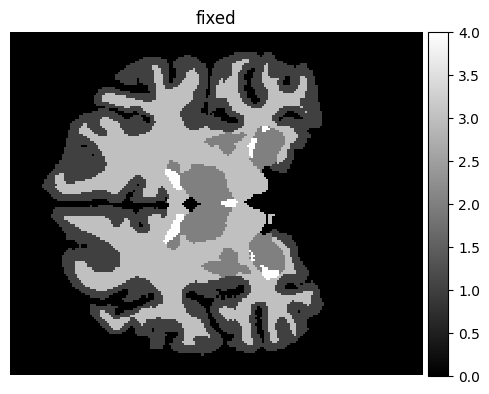

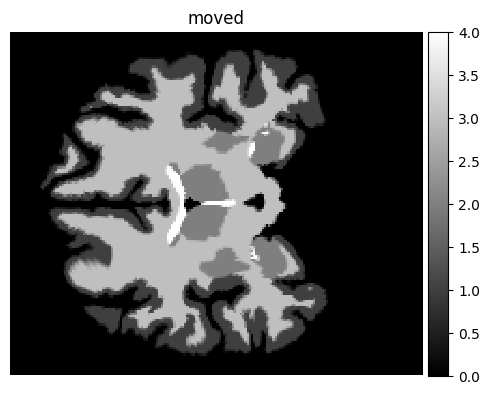

In [15]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

## Registration #2

### Brains

In [16]:
validate[2]

'/content/OASIS/OASIS_OAS1_0012_MR1/slice_norm.nii.gz'

In [17]:
validate[3]

'/content/OASIS/OASIS_OAS1_0015_MR1/slice_norm.nii.gz'

In [18]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[2]
registration_args.moving = validate[3]
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(
    registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warp = vxm.networks.VxmDense.load(registration_args.model, **config).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 0s 305ms/step


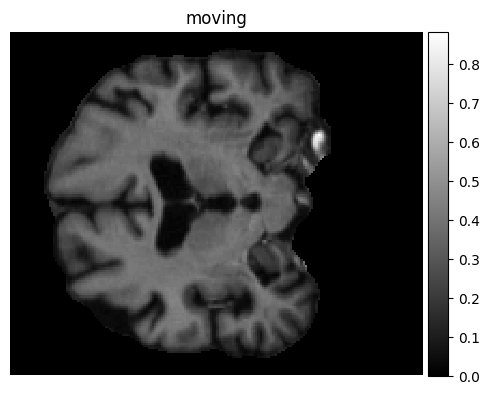

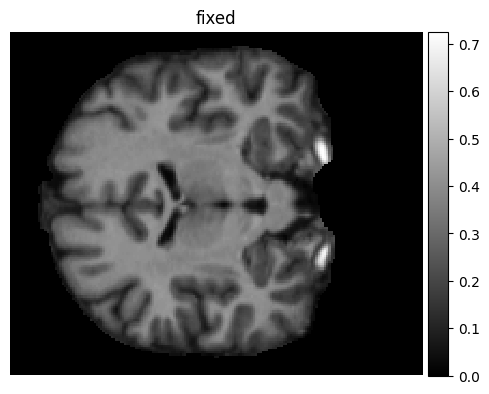

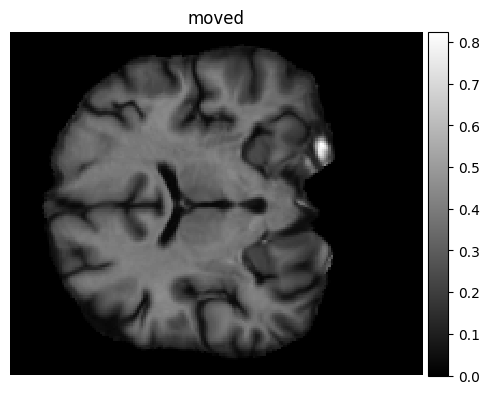

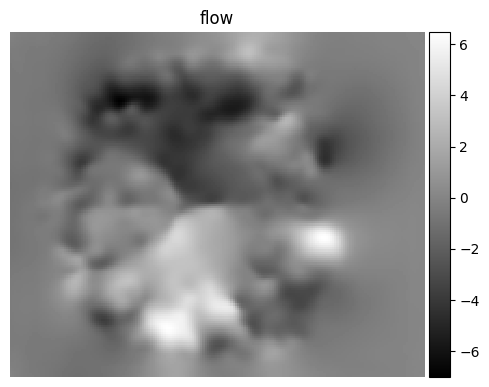

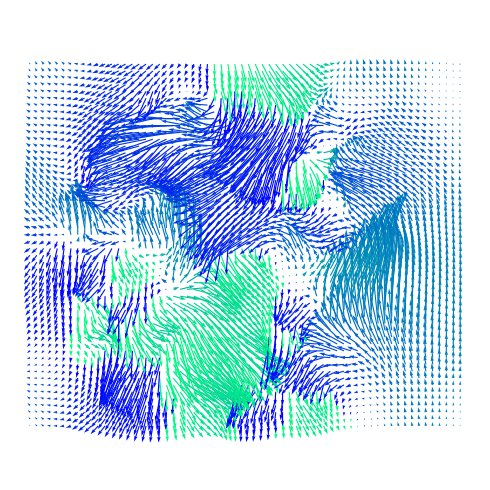

In [19]:
titles = ['moving', 'fixed', 'moved', 'flow']
for index, image in enumerate([moving, fixed, moved, warp]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

# visualize flow
flow = warp.squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

print()
print()

### Slice seg24

In [20]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[2].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moving = validate[3].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 221ms/step


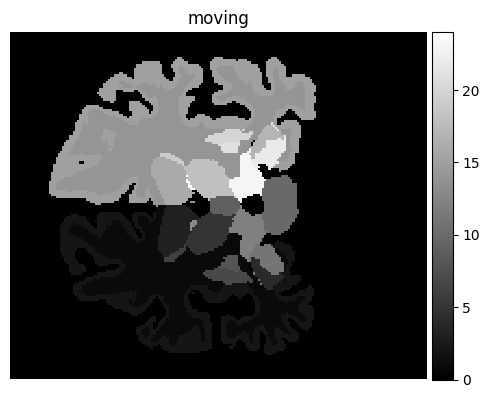

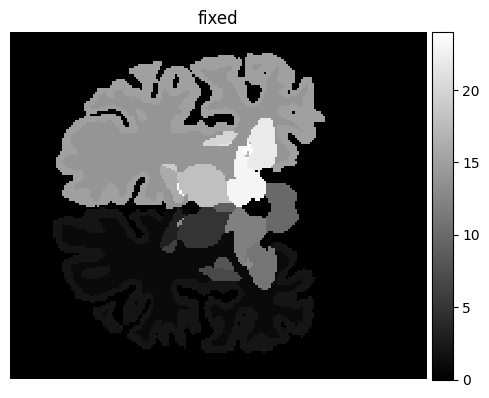

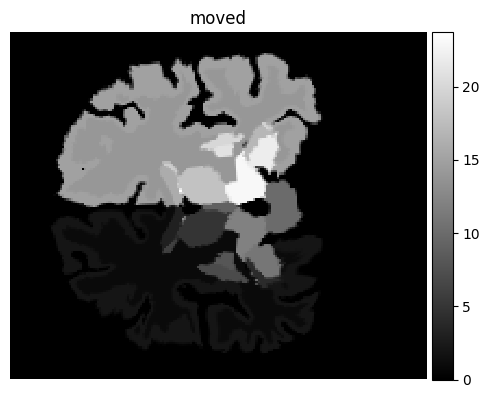

In [21]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

### Slice seg4

In [22]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[2].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moving = validate[3].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 219ms/step


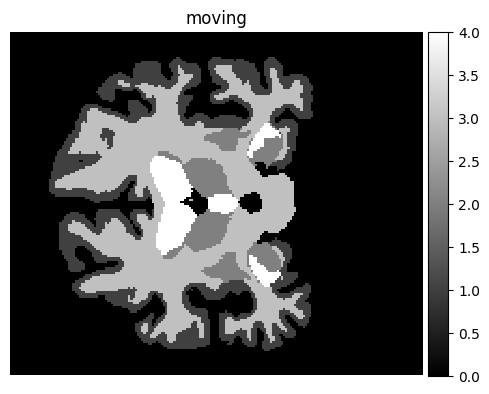

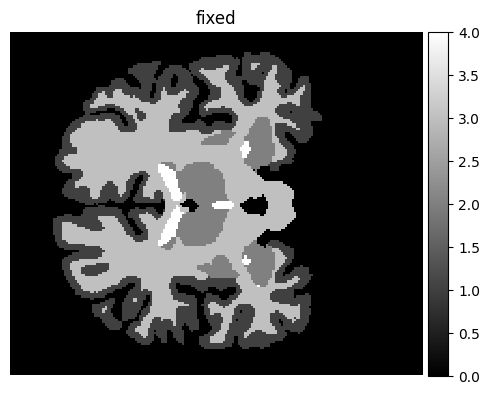

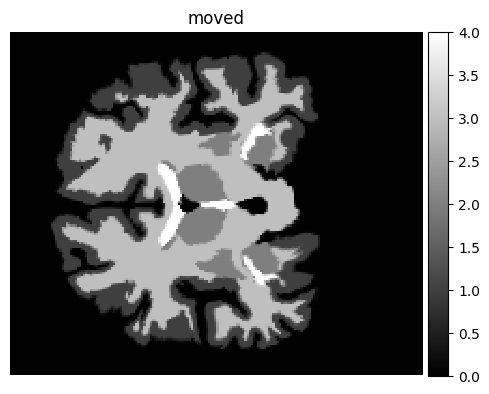

In [23]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

## Registration #3

### Brains

In [24]:
validate[4]

'/content/OASIS/OASIS_OAS1_0019_MR1/slice_norm.nii.gz'

In [25]:
validate[5]

'/content/OASIS/OASIS_OAS1_0029_MR1/slice_norm.nii.gz'

In [26]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[4]
registration_args.moving = validate[5]
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(
    registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warp = vxm.networks.VxmDense.load(registration_args.model, **config).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 226ms/step


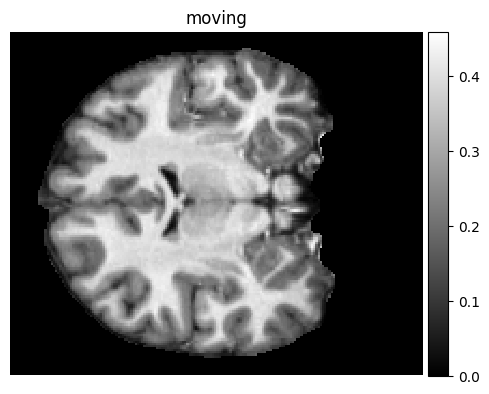

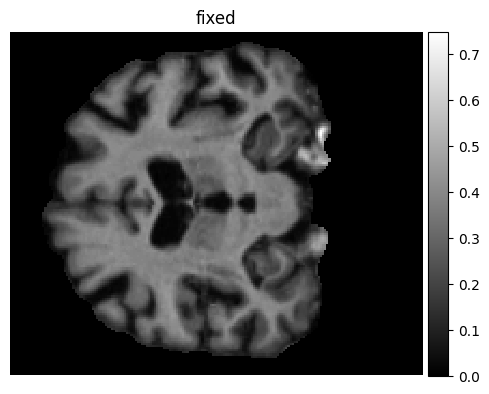

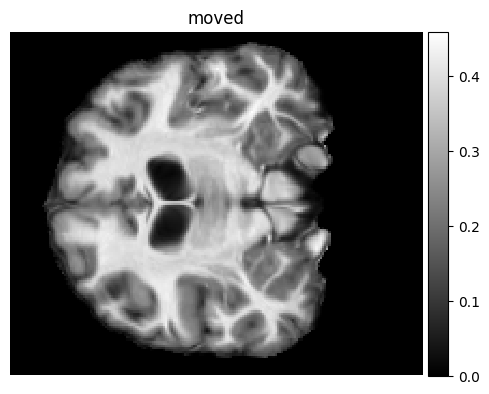

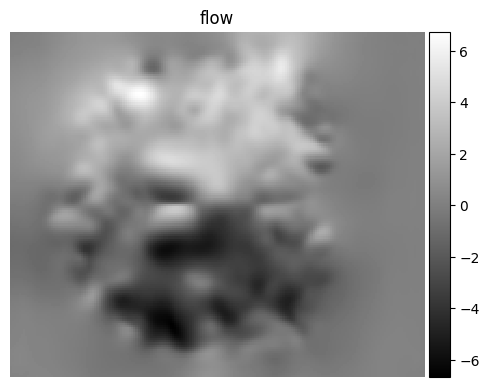

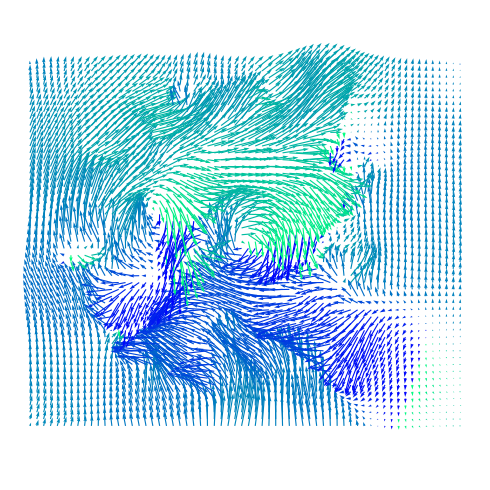

In [27]:
titles = ['moving', 'fixed', 'moved', 'flow']
for index, image in enumerate([moving, fixed, moved, warp]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

# visualize flow
flow = warp.squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

print()
print()

### Slice seg24

In [28]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[4].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moving = validate[5].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 214ms/step


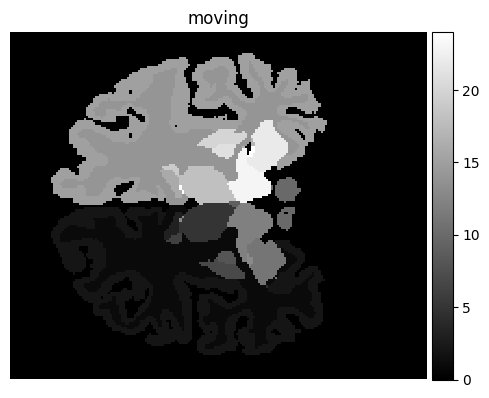

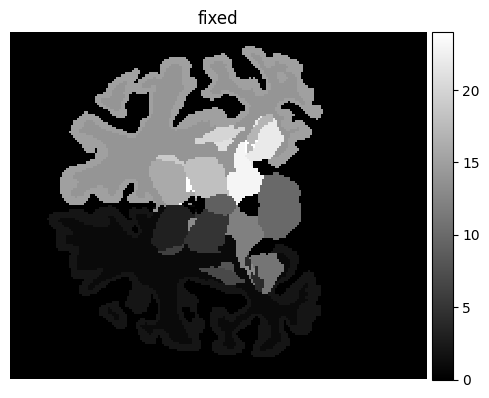

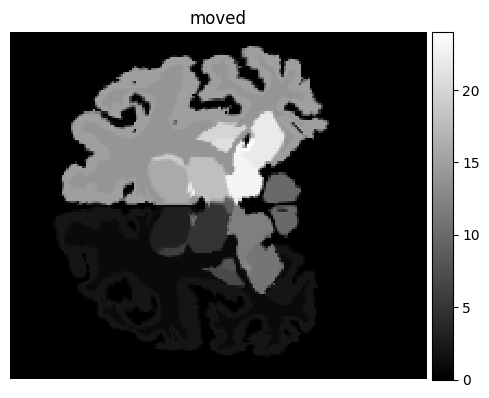

In [29]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

### Slice seg4

In [30]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[4].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moving = validate[5].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 1s 570ms/step


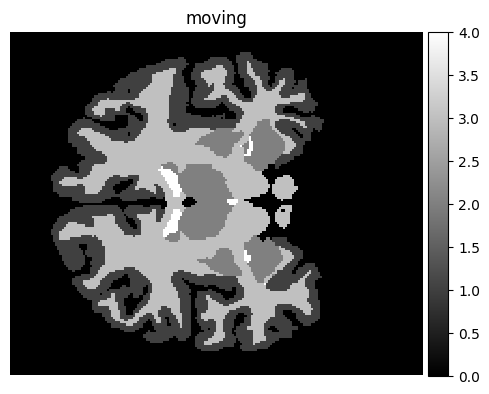

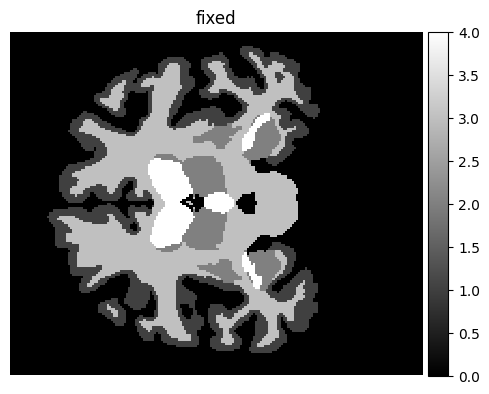

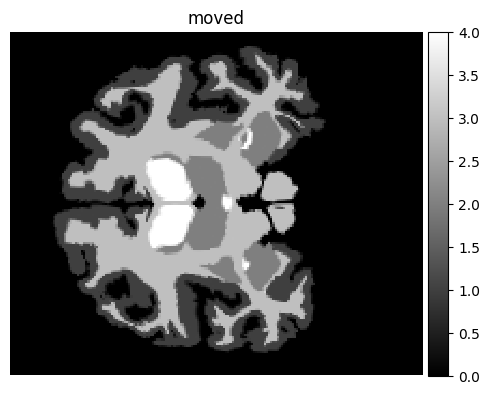

In [31]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

## Registration #4

### Brains

In [32]:
validate[6]

'/content/OASIS/OASIS_OAS1_0035_MR1/slice_norm.nii.gz'

In [33]:
validate[7]

'/content/OASIS/OASIS_OAS1_0038_MR1/slice_norm.nii.gz'

In [34]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[6]
registration_args.moving = validate[7]
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(
    registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warp = vxm.networks.VxmDense.load(registration_args.model, **config).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 329ms/step


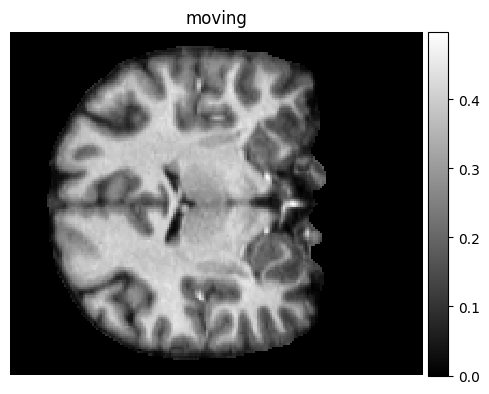

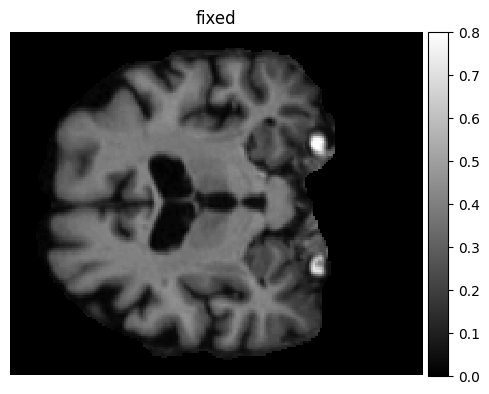

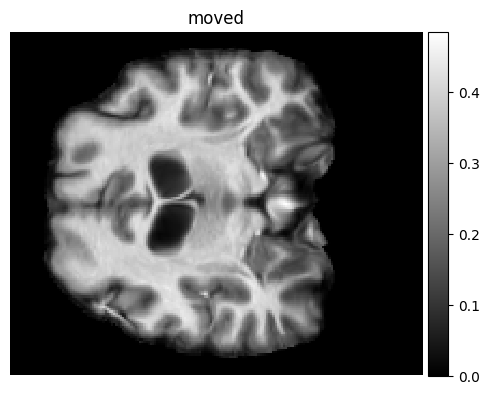

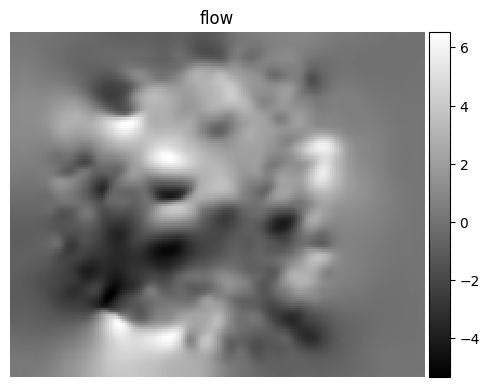

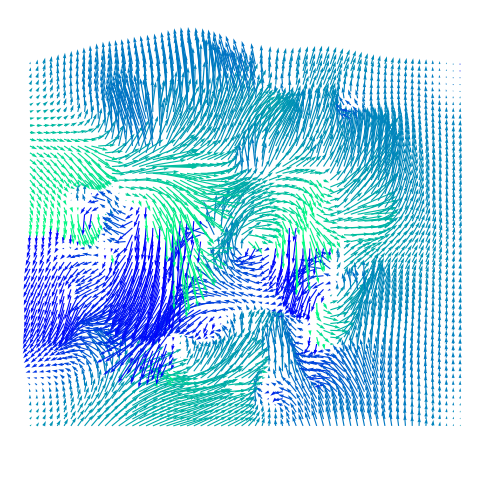

In [35]:
titles = ['moving', 'fixed', 'moved', 'flow']
for index, image in enumerate([moving, fixed, moved, warp]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

# visualize flow
flow = warp.squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

print()
print()

### Slice seg24

In [36]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[6].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moving = validate[7].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 199ms/step


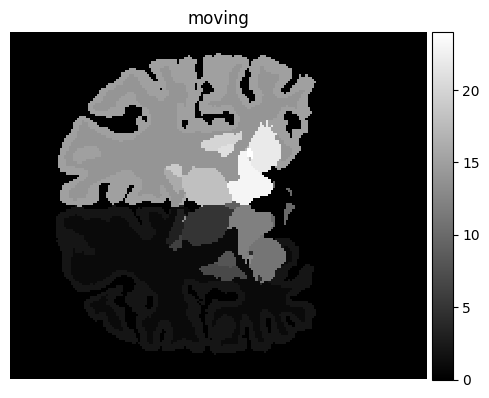

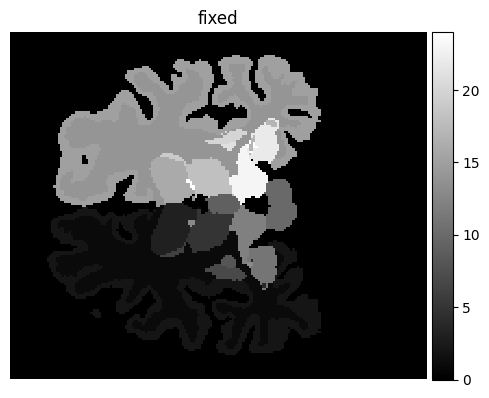

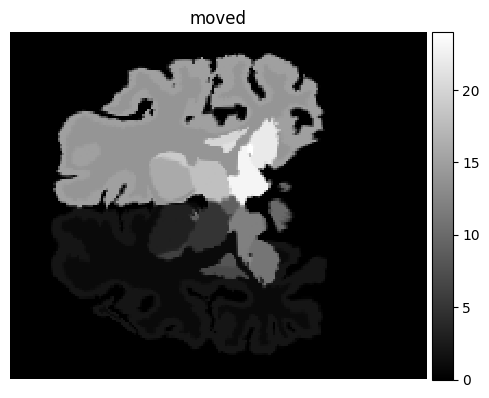

In [37]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

### Slice seg4

In [38]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[6].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moving = validate[7].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 226ms/step


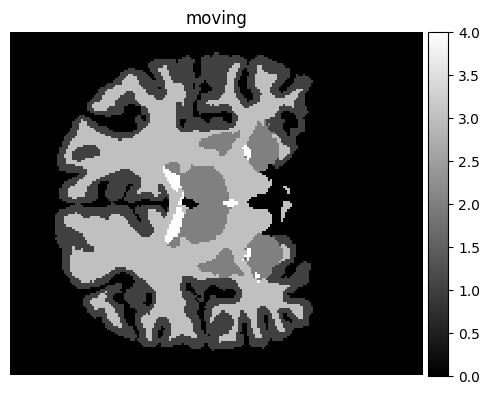

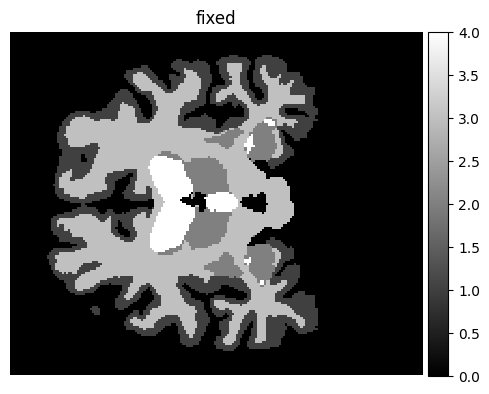

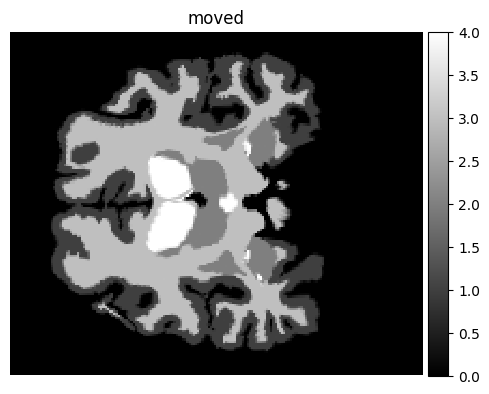

In [39]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

## Registration #5

### Brains

In [40]:
validate[8]

'/content/OASIS/OASIS_OAS1_0040_MR1/slice_norm.nii.gz'

In [41]:
validate[9]

'/content/OASIS/OASIS_OAS1_0052_MR1/slice_norm.nii.gz'

In [42]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[8]
registration_args.moving = validate[9]
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(
    registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warp = vxm.networks.VxmDense.load(registration_args.model, **config).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 309ms/step


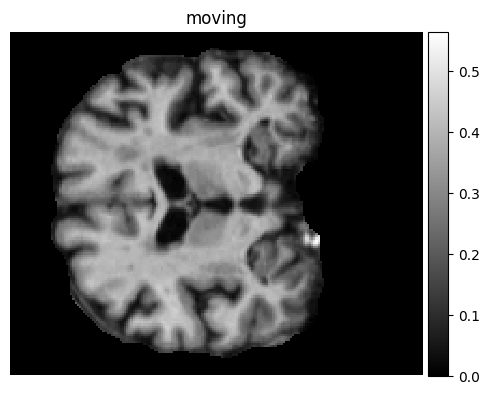

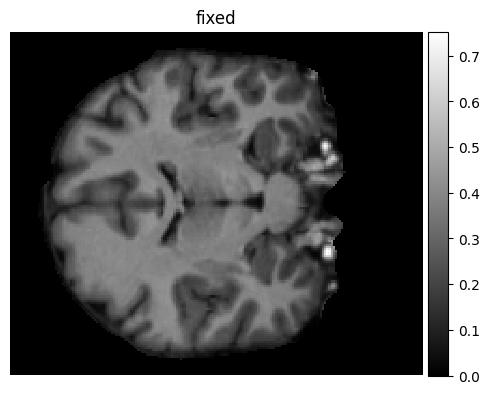

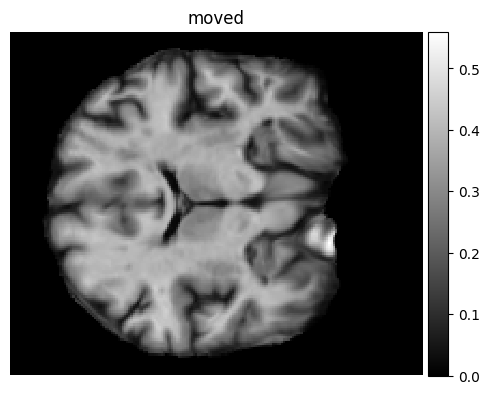

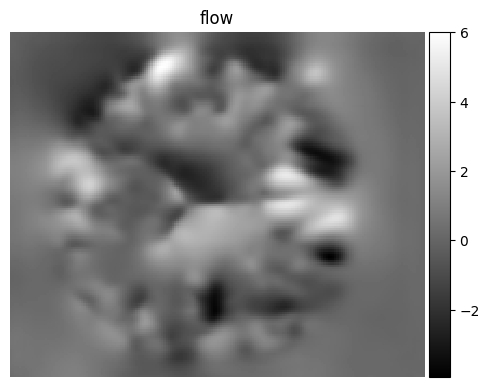

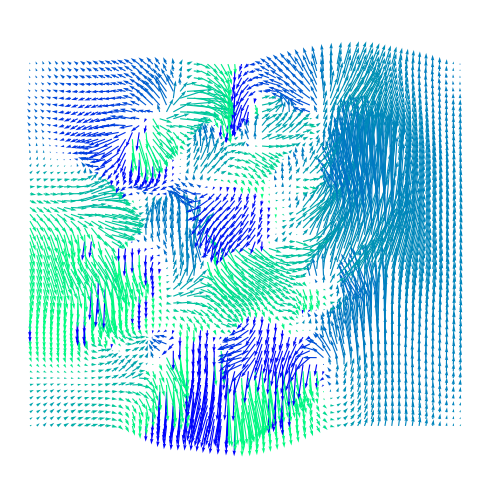

In [43]:
titles = ['moving', 'fixed', 'moved', 'flow']
for index, image in enumerate([moving, fixed, moved, warp]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

# visualize flow
flow = warp.squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

print()
print()

### Slice seg24

In [44]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[8].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moving = validate[9].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 319ms/step


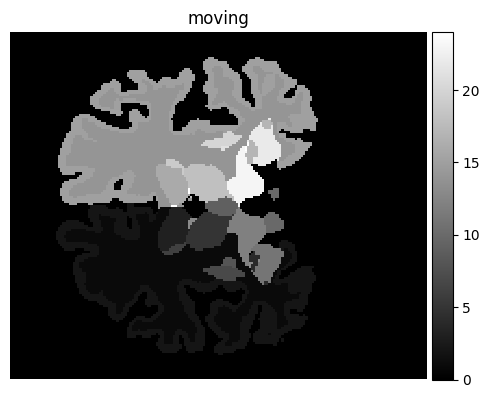

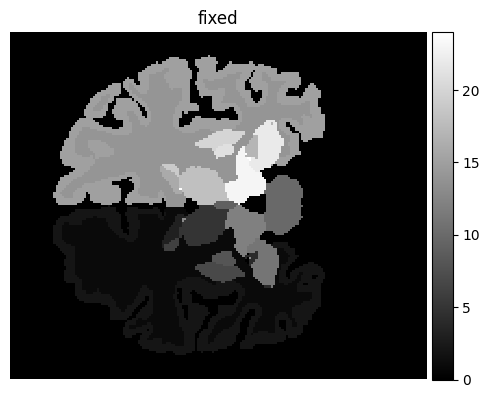

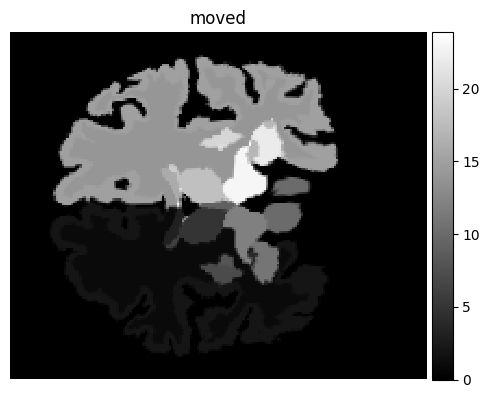

In [45]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

### Slice seg4

In [46]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[8].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moving = validate[9].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 342ms/step


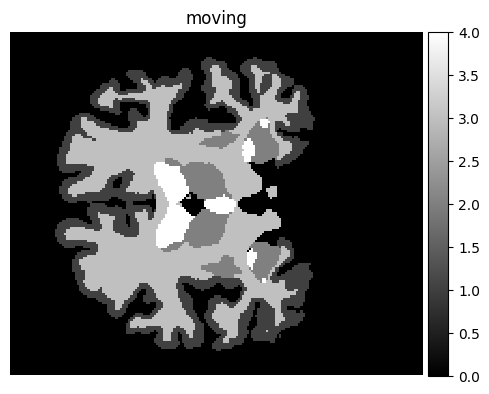

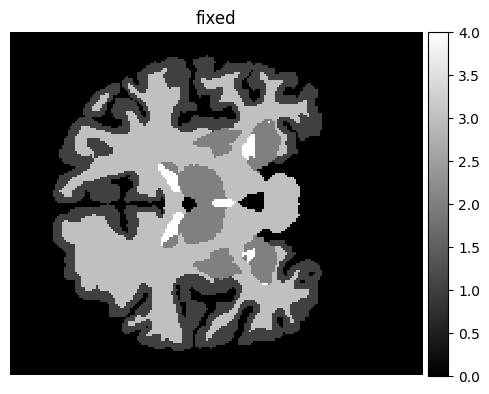

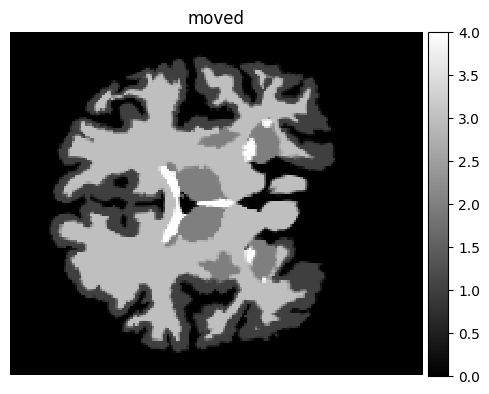

In [47]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

# Testing (Dice Score)

In [48]:
# keep track of all dice scores
reg_times = []
dice_means = []

img_pairs = []
seg_pairs = []

class TestingArgs:
  model: str = None
  labels = None

testing_args = TestingArgs()
testing_args.model = '/content/models/2000.h5'

labels = np.load(testing_args.labels) if testing_args.labels else None

for i in range(0, 83, 2):
  # to the last image we compare with first because the number is odd
  if i == 82:
    img_pairs.append([validate[i], 
                      validate[0]])
    seg_pairs.append([validate[i].replace('slice_norm', 'slice_seg24'), 
                      validate[0].replace('slice_norm', 'slice_seg24')])
  else:
    img_pairs.append([validate[i], 
                      validate[i+1]])
    seg_pairs.append([validate[i].replace('slice_norm', 'slice_seg24'), 
                      validate[i+1].replace('slice_norm', 'slice_seg24')])

with tf.device(device):
    # load model and build nearest-neighbor transfer model
    model = vxm.networks.VxmDense.load(testing_args.model, input_model=None)
    registration_model = model.get_registration_model()
    inshape = registration_model.inputs[0].shape[1:-1]
    transform_model = vxm.networks.Transform(inshape, interp_method='nearest')

    for i in range(len(img_pairs)):

        # load moving image and seg
        moving_vol = vxm.py.utils.load_volfile(
            img_pairs[i][0], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        moving_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][0], np_var='seg', add_batch_axis=True, add_feat_axis=add_feat_axis)

        # load fixed image and seg
        fixed_vol = vxm.py.utils.load_volfile(
            img_pairs[i][1], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        fixed_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][1], np_var='seg')

        # predict warp and time
        start = time.time()
        warp = registration_model.predict([moving_vol, fixed_vol])
        reg_time = time.time() - start
        if i != 0:
            # first keras prediction is generally rather slow
            reg_times.append(reg_time)

        # apply transform
        warped_seg = transform_model.predict([moving_seg, warp]).squeeze()

        # compute volume overlap (dice)
        overlap = vxm.py.utils.dice(warped_seg, fixed_seg, labels=labels)
        dice_means.append(np.mean(overlap))
        print('Pair %d    Reg Time: %.4f    Dice: %.4f +/- %.4f' % (i + 1, reg_time,
                                                                    np.mean(overlap),
                                                                    np.std(overlap)))

print()
print('Avg Reg Time: %.4f +/- %.4f  (skipping first prediction)' % (np.mean(reg_times),
                                                                    np.std(reg_times)))
print('Avg Dice: %.4f +/- %.4f' % (np.mean(dice_means), np.std(dice_means)))

1/1 [==============================] - 0s 140ms/step
Pair 1    Reg Time: 2.2596    Dice: 0.6713 +/- 0.2869
1/1 [==============================] - 0s 19ms/step
Pair 2    Reg Time: 0.0825    Dice: 0.6775 +/- 0.2843
1/1 [==============================] - 0s 19ms/step
Pair 3    Reg Time: 0.0823    Dice: 0.6845 +/- 0.2434
1/1 [==============================] - 0s 21ms/step
Pair 4    Reg Time: 0.0736    Dice: 0.6745 +/- 0.2592
1/1 [==============================] - 0s 22ms/step
Pair 5    Reg Time: 0.0745    Dice: 0.7475 +/- 0.2092
1/1 [==============================] - 0s 19ms/step
Pair 6    Reg Time: 0.0787    Dice: 0.6866 +/- 0.2520
1/1 [==============================] - 0s 19ms/step
Pair 7    Reg Time: 0.0855    Dice: 0.7532 +/- 0.2413
1/1 [==============================] - 0s 20ms/step
Pair 8    Reg Time: 0.0756    Dice: 0.7217 +/- 0.2174
1/1 [==============================] - 0s 24ms/step
Pair 9    Reg Time: 0.1181    Dice: 0.7393 +/- 0.2172
1/1 [==============================] - 0s 19m

# Run scripts

In [ ]:
# write a list of OASIS subjects to a training file
import pathlib
path = pathlib.Path('/content/OASIS')
subj_lst_m = [str(f/'slice_norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]
with open('train_list.txt','w') as tfile:
	tfile.write('\n'.join(subj_lst_m))

In [ ]:
%run -i /content/voxelmorph/scripts/tf/train.py \
--img-list 'train_list.txt' \
--epochs 100

In [ ]:
%run /content/voxelmorph/scripts/tf/register.py \
--moving /content/OASIS/OASIS_OAS1_0001_MR1/slice_orig.nii.gz \
--fixed /content/OASIS/OASIS_OAS1_0001_MR1/slice_norm.nii.gz \
--moved moved.nii.gz \
--warp warp.nii.gz \
--model /content/models/0100.h5 \
--gpu 0

In [ ]:
%run -i /content/voxelmorph/scripts/tf/test.py \
--model /content/models/0100.h5 \
--pairs /content/pairs.txt \
--img-prefix /content/OASIS/ \
--seg-prefix /content/OASIS/ \
--img-suffix /slice_norm.nii.gz \
--seg-suffix /slice_seg24.nii.gz

# Some annotations

Explain of testing script:

https://github.com/voxelmorph/voxelmorph/issues/373

To make voxelmorph work with the BPCA pooling layer follow these steps:

1. Copy the [BPCA Pooling](https://github.com/Uemerson/masters-degree-in-computer-science-from-unesp/blob/main/utils/BPCAPooling.py)
2. In the /content/voxelmorph/voxelmorph/tf/networks.py file, paste the BPCA Pooling code
2. In the /content/voxelmorph/voxelmorph/tf/networks.py file, replace in the Unet class the following codes:

```
last = MaxPooling(max_pool[level], name='%s_enc_pooling_%d' % (name, level))(last)
```

to:

```
b, w, h, c = last.get_shape()
            
last = BPCAPooling(expected_shape=(w,h,c), name='%s_enc_pooling_%d' % (name, level))(last)
```